### xgboost model to predict mean player outcomes
used in conjunction with nn algs to determine mean wrc for player. Three diffrent models based on available data then combinded to create an xgb predection.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
function_dir = 'C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/tools'
sys.path.append(function_dir)

os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/')

In [2]:
# import data
data_02_24 = pd.read_csv('./data/cleaned/data_02_24.csv')
df = data_02_24.drop(columns=['Unnamed: 0'])
df = df.dropna()

#### Normalize Data



In [3]:
from tools.zscore import normalize
z_score_df = normalize(df)

### xgboost model

In [9]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

make wrc+ value the next year

In [10]:
# remove 2024 to train model bc we do not know the following year
train_z = z_score_df[z_score_df['Season'] < 2024].copy()
train_z['next_wrc+'] = np.nan # empty col


for idx in train_z.index:
    # retrive name, season
    name = train_z.loc[idx, 'Name']
    season = train_z.loc[idx, 'Season']
    # full df
    next_year_noscale = df[(df['Name'] == name) & (df['Season'] == season + 1)]
    next_year_scaled = z_score_df[(z_score_df['Name'] == name) & (z_score_df['Season'] == season + 1)]

    # add to df
    if not next_year_noscale.empty:
        train_z.loc[idx, 'next_wrc+'] = next_year_noscale['wRC+'].iloc[0]
        train_z.loc[idx, 'next_pa'] = next_year_scaled['PA'].iloc[0] # need for later anaylsis

# remove rows of nas | players retired etc.
train_z = train_z.dropna(subset=['next_wrc+'])

# display
train_z.head()

,Name,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,...,WAR,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%,next_wrc+,next_pa
0,brent clevlen,2007,74.826870,85.958971,74.686219,193.060161,107.344122,43.282571,98.653170,96.363387,...,89.901996,138.703183,88.950287,71.666459,22.211544,37.187201,169.893575,204.596460,40.620897,76.461476
1,brett hayes,2009,74.297907,90.367791,72.475999,127.859623,108.219882,117.931506,99.866315,98.235778,...,91.580480,170.668602,80.735141,60.421763,105.381033,65.578050,147.469352,199.428878,68.663763,79.520422
2,carlos peguero,2014,75.723755,96.257739,107.348483,147.612705,148.436984,92.738037,100.377615,97.711317,...,91.256604,122.457976,73.452584,41.259125,91.336666,33.462464,156.578380,183.278087,92.949027,79.756145
5,domingo santana,2014,76.161502,80.937328,92.701724,191.474452,27.049843,35.300547,100.388715,95.262033,...,88.346507,104.533169,117.006084,37.346862,46.681858,34.973860,163.064364,174.135337,111.757590,85.107766
8,eliezer alfonzo,2008,75.550163,100.406271,73.751790,132.428726,56.320994,41.119256,98.386518,95.994778,...,89.755634,150.740042,83.057646,74.748966,56.559446,48.895200,160.671646,180.916565,19.347656,80.120523


intial selection of data before feature selection

In [11]:
train_z1 = train_z[train_z['next_pa'] > 85] # more then 250 PA in the next season
train_z1 = train_z1[train_z1['Season'] < 2024]
X = train_z1.drop(columns=['Name', 'Season','next_wrc+', 'next_pa', 'BsR', 'Def', 'Age'])
Y = train_z1['next_wrc+']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=26)

Feature selection, testing both PCA and a more intuitive approach
<br>
<small> Ended up not using PCA. My intutitive selection of features ended up being too accurate

In [12]:
features_reduction = PCA(n_components=.99).fit_transform(X)

train test split

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=26)

In [14]:
# Calculate correlation matrix
corr = train_z1.corr(numeric_only=True)

# next_wrc+ corr
corr_with_wrc = corr['next_wrc+'].sort_values(ascending=False)

print(corr_with_wrc)

next_wrc+     1.000000
next_pa       0.478417
Off           0.453600
wRC+          0.374286
WAR           0.351801
BB%           0.290306
PA            0.247713
BABIP         0.088057
Z-Swing%      0.047435
SwStr%        0.012478
K%            0.004955
Season       -0.006838
BsR          -0.020073
Age          -0.020977
O-Contact%   -0.045994
Contact%     -0.059993
Z-Contact%   -0.077314
CSW%         -0.080204
O-Swing%     -0.129966
Def          -0.186977
Name: next_wrc+, dtype: float64


In [13]:
model = xgb.XGBRegressor(n_jobs=-1, n_estimators=50000, device = "cuda", eval_metric = ['mae', 'rmse']) 

##### hyper para tuning

random search to narrow space into grid search

In [21]:
from sklearn.model_selection import RandomizedSearchCV

In [22]:
rnd_search_params = {
    'learning_rate': np.linspace(0.05, 0.2, 4),          
    'max_leaves': np.linspace(1, 40, 20, dtype=int),     
    'min_child_weight': np.linspace(1, 20, 10),         
    'subsample': np.linspace(0.3, 0.9, 7),               
    'colsample_bytree': np.linspace(0.4, 1, 7),          
    'early_stopping_rounds': np.linspace(10, 100, 10, dtype=int),  
    'max_depth': np.linspace(0, 40, 20, dtype=int)       
}

rnd_searcher = RandomizedSearchCV(model, rnd_search_params, random_state=26, n_iter=250, cv=5, n_jobs=-1, verbose=4)
rnd_searcher.fit(xtrain, ytrain, eval_set=[(xtest, ytest)])
print(rnd_searcher.best_params_)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[0]	validation_0-mae:29.02709	validation_0-rmse:39.24734
[1]	validation_0-mae:28.75311	validation_0-rmse:38.93006
[2]	validation_0-mae:28.49083	validation_0-rmse:38.62693
[3]	validation_0-mae:28.24847	validation_0-rmse:38.33888
[4]	validation_0-mae:28.03798	validation_0-rmse:38.09798
[5]	validation_0-mae:27.84207	validation_0-rmse:37.87629
[6]	validation_0-mae:27.66408	validation_0-rmse:37.66678
[7]	validation_0-mae:27.51224	validation_0-rmse:37.48545
[8]	validation_0-mae:27.35714	validation_0-rmse:37.30446
[9]	validation_0-mae:27.21828	validation_0-rmse:37.12731
[10]	validation_0-mae:27.09402	validation_0-rmse:36.98753
[11]	validation_0-mae:26.98714	validation_0-rmse:36.86098
[12]	validation_0-mae:26.86619	validation_0-rmse:36.72291
[13]	validation_0-mae:26.76819	validation_0-rmse:36.60464
[14]	validation_0-mae:26.66981	validation_0-rmse:36.48465
[15]	validation_0-mae:26.59986	validation_0-rmse:36.39575
[16]	validation_0-

c:\Users\dalto\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:45:47] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[17]	validation_0-mae:26.42098	validation_0-rmse:36.18205
[18]	validation_0-mae:26.36312	validation_0-rmse:36.09814
[19]	validation_0-mae:26.28960	validation_0-rmse:36.01911
[20]	validation_0-mae:26.22004	validation_0-rmse:35.93465
[21]	validation_0-mae:26.16531	validation_0-rmse:35.86880
[22]	validation_0-mae:26.10831	validation_0-rmse:35.80144
[23]	validation_0-mae:26.06995	validation_0-rmse:35.75406
[24]	validation_0-mae:26.01778	validation_0-rmse:35.68507
[25]	validation_0-mae:25.97984	validation_0-rmse:35.63733
[26]	validation_0-mae:25.93081	validation_0-rmse:35.59215
[27]	validation_0-mae:25.89214	validation_0-rmse:35.53803
[28]	validation_0-mae:25.86099	validation_0-rmse:35.50208
[29]	validation_0-mae:25.83239	validation_0-rmse:35.46330
[30]	validation_0-mae:25.79475	validation_0-rmse:35.42043
[31]	validation_0-mae:25.76538	validation_0-rmse:35.38725
[32]	validation_0-mae:25.73346	validation_0-rmse:35.34757
[33]	validation_0-mae:25.71224	validation_0-rmse:35.32009
[34]	validatio

grid search

In [25]:
from sklearn.model_selection import GridSearchCV
grid_search_params = {
    'learning_rate': [0.05, 0.1],   
    'max_leaves': [10, 12, 14],
    'min_child_weight': [10, 11, 12],      
    'subsample': [0.4, 0.5, 0.6],           
    'colsample_bytree':[0.7, 0.8, 0.9],     
    'early_stopping_rounds':[40, 50, 60],
    'max_depth': [2, 3, 4]
}

In [26]:
grid_searcher = GridSearchCV(model, grid_search_params, cv=5, n_jobs=-1, verbose=4)
grid_searcher.fit(xtrain, ytrain, eval_set=[(xtest, ytest)])
print(grid_searcher.best_params_)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
[0]	validation_0-mae:29.02709	validation_0-rmse:39.24734
[1]	validation_0-mae:28.75311	validation_0-rmse:38.93006
[2]	validation_0-mae:28.49083	validation_0-rmse:38.62693
[3]	validation_0-mae:28.24847	validation_0-rmse:38.33888
[4]	validation_0-mae:28.03798	validation_0-rmse:38.09798
[5]	validation_0-mae:27.84207	validation_0-rmse:37.87629
[6]	validation_0-mae:27.66408	validation_0-rmse:37.66678
[7]	validation_0-mae:27.51224	validation_0-rmse:37.48545
[8]	validation_0-mae:27.35714	validation_0-rmse:37.30446
[9]	validation_0-mae:27.21828	validation_0-rmse:37.12731
[10]	validation_0-mae:27.09402	validation_0-rmse:36.98753
[11]	validation_0-mae:26.98714	validation_0-rmse:36.86098
[12]	validation_0-mae:26.86619	validation_0-rmse:36.72291
[13]	validation_0-mae:26.76819	validation_0-rmse:36.60464
[14]	validation_0-mae:26.66981	validation_0-rmse:36.48465
[15]	validation_0-mae:26.59986	validation_0-rmse:36.39575
[16]	validation_0

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:01:28] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[32]	validation_0-mae:25.72157	validation_0-rmse:35.34697
[33]	validation_0-mae:25.70125	validation_0-rmse:35.32011
[34]	validation_0-mae:25.67403	validation_0-rmse:35.28284
[35]	validation_0-mae:25.66619	validation_0-rmse:35.27073
[36]	validation_0-mae:25.64684	validation_0-rmse:35.24754
[37]	validation_0-mae:25.62243	validation_0-rmse:35.21811
[38]	validation_0-mae:25.60515	validation_0-rmse:35.18815
[39]	validation_0-mae:25.59280	validation_0-rmse:35.16932
[40]	validation_0-mae:25.57870	validation_0-rmse:35.15223
[41]	validation_0-mae:25.56098	validation_0-rmse:35.13439
[42]	validation_0-mae:25.54226	validation_0-rmse:35.11168
[43]	validation_0-mae:25.53265	validation_0-rmse:35.09686
[44]	validation_0-mae:25.51378	validation_0-rmse:35.07058
[45]	validation_0-mae:25.50479	validation_0-rmse:35.06206
[46]	validation_0-mae:25.50668	validation_0-rmse:35.06116
[47]	validation_0-mae:25.49168	validation_0-rmse:35.04557
[48]	validation_0-mae:25.47789	validation_0-rmse:35.03364
[49]	validatio

In [ ]:
opti_para = {'colsample_bytree': 0.7, 'early_stopping_rounds': 30, 'learning_rate': 0.05, 'max_depth': 3, 'max_leaves': 7, 'min_child_weight': 10, 'subsample': 0.6}
# update model parameters
model.set_params(**opti_para)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device='cuda', early_stopping_rounds=30,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=7, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50000,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

xgb.cv for detailed analysis, optimal boosting rounds

In [ ]:
matrix_data = xgb.DMatrix(X, Y)
fmodel = xgb.cv(opti_para, dtrain=matrix_data, num_boost_round=1000, nfold=10, metrics= ['rmse', 'mae'], as_pandas=True, seed=26, early_stopping_rounds=30)
fmodel.head()

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:55:14] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "early_stopping_rounds" } are not used.

  warnings.warn(smsg, UserWarning)


,train-rmse-mean,train-rmse-std,train-mae-mean,train-mae-std,test-rmse-mean,test-rmse-std,test-mae-mean,test-mae-std
0,26.245661,0.086104,20.626680,0.067892,26.246080,0.790229,20.634071,0.631467
1,25.996312,0.081510,20.435644,0.064148,26.006632,0.782614,20.449431,0.625141
2,25.765863,0.080938,20.257692,0.063198,25.781601,0.768487,20.276803,0.615719
3,25.548442,0.082061,20.087480,0.063710,25.574311,0.755769,20.114675,0.606531
4,25.351474,0.081500,19.934919,0.064856,25.386280,0.741863,19.969880,0.593398


#### opti model

In [15]:
# update model parameters
model.set_params(**opti_para)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device='cuda', early_stopping_rounds=30,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=7, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50000,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [16]:
model.set_params(n_estimators=150, early_stopping_rounds=None)
model.fit(xtrain, ytrain)
ypreds = model.predict(xtest)

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:06:34] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


##### Results DF

In [17]:
results_df = xtest.copy()
results_df['Name'] = train_z.loc[xtest.index, 'Name']
results_df['Season'] = train_z.loc[xtest.index, 'Season']
results_df['next_pa'] = train_z.loc[xtest.index, 'next_pa']
results_df['pred_wrc+'] = ypreds
results_df['season_plus1_wrc+'] = ytest
results_df = results_df[['Name', 'Season', 'pred_wrc+', 'season_plus1_wrc+', 'next_pa']]
results_df['miss'] = (results_df['season_plus1_wrc+'] - results_df['pred_wrc+']).abs()
results_df.head()

,Name,Season,pred_wrc+,season_plus1_wrc+,next_pa,miss
654,jared walsh,2019,92.854698,150.261048,90.260423,57.406350
7412,ryan ludwick,2013,101.336998,90.485256,97.063907,10.851742
2464,kyle schwarber,2022,120.797386,119.640085,114.823849,1.157301
999,cesar izturis,2011,86.305435,55.504495,85.089057,30.800940
9176,starling marte,2020,99.067177,131.971256,105.082818,32.904079


##### Model Eval

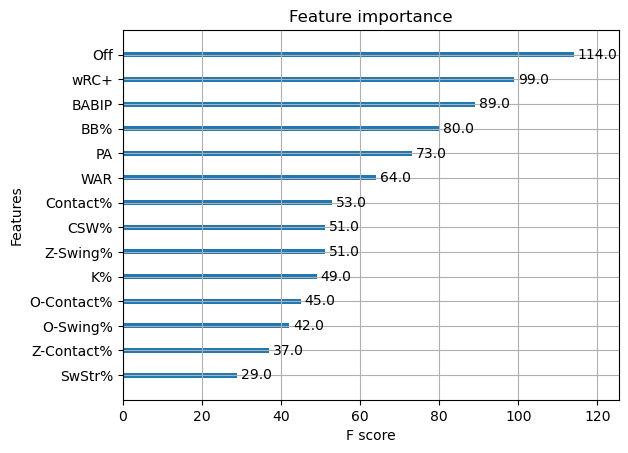

In [18]:
xgb.plot_importance(model)
plt.show()

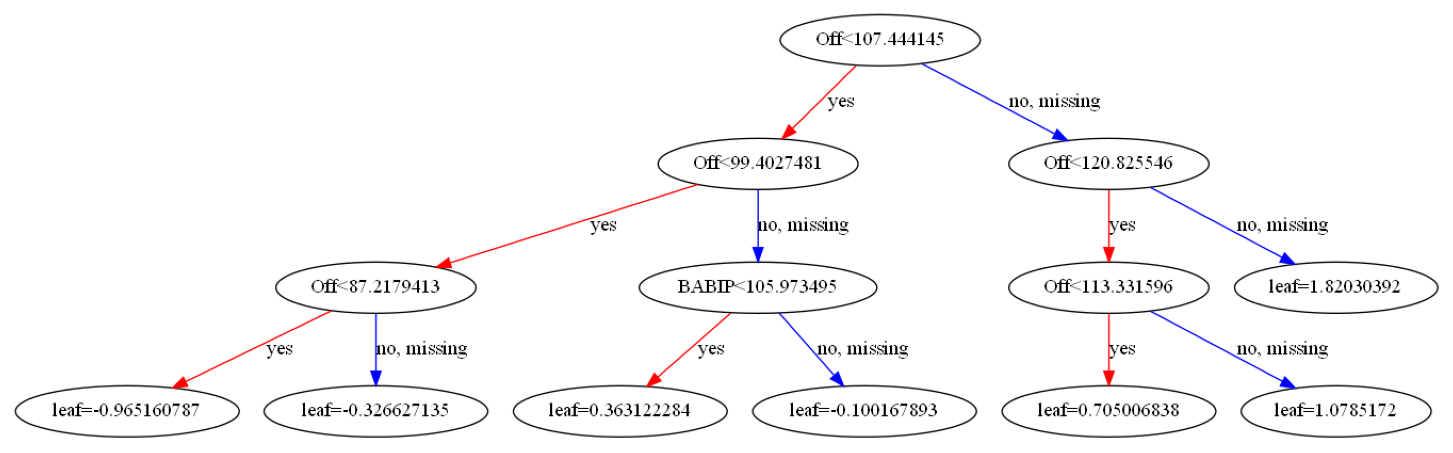

In [19]:
xgb.plot_tree(model, num_trees=1)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

#### Metrics

In [20]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

r2 = r2_score(y_true=ytest, y_pred=ypreds)
mae = mean_absolute_error(y_true=ytest, y_pred=ypreds)
rmse = root_mean_squared_error(y_true=ytest, y_pred=ypreds)

print(f"R^2: {r2} \n mse: {mae} \n rmse: {rmse}")

R^2: 0.24087264625490024 
 mse: 18.11195466327639 
 rmse: 23.108639964358574


#### 2025 Predections

In [23]:
season = z_score_df[z_score_df['Season'] >= 2024].copy()
season = season.reset_index()
season.drop(columns=['index'], inplace=True)
season_pred = season.drop(columns=['Name', 'Season', 'BsR', 'Def', 'Age'])

In [24]:
preds_2025 = model.predict(season_pred)
preds_2025 = pd.DataFrame(preds_2025)
preds_2025['Name'] = season['Name']

In [25]:
preds_2025.to_csv('./models/wrc_models/2025_Predections/reg_02_23_preds.csv')